In [1]:
import numpy as np
from numba import njit
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt


c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [82]:
def func(x, y):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x, y = np.meshgrid(x, y)
    
    return x*x + 2*y*y

def dfunc(x, y):
    # df = 2*x dx + 4y dy
    return np.asarray([2*x, 4*y])

def show(x, y, z, arrow=None):
    _x, _y = np.meshgrid(x, y)

    plt.pcolormesh(_x, _y, z, cmap='viridis_r')
    if arrow:
        for a in arrow:
            plt.arrow(*a)

    plt.colorbar()
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()


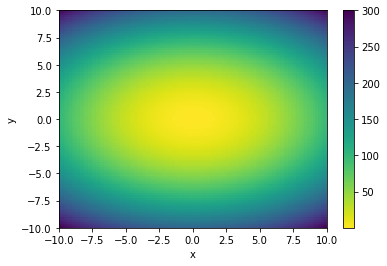

In [83]:

x, y = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
z = func(x, y)


show(x, y, z)


In [102]:
func(9, 9), -dfunc(4, -1)

(243, array([-8,  4]))

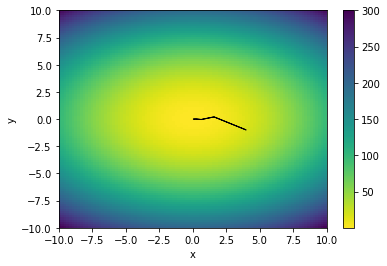

In [101]:
x0 = np.asarray([4, -1])
k = 0.3
arrows = []

for i in range(5):
    _g = dfunc(*x0)
    g = -k * _g #/ np.sqrt(_g.dot(_g))
    x1 = x0 + g
    arrows.append([*x0, *g])
    x0 = x1

show(x, y, z, arrow=arrows)


In [402]:
i, j = 500, 3

A = np.arange(5, i*j + 5).reshape((i, j)).astype(np.float64)
A = np.random.random((i, j))
A *= 1
A

array([[0.15412566, 0.09976438, 0.56432706],
       [0.87578015, 0.58500296, 0.95658911],
       [0.59001274, 0.66820504, 0.9916044 ],
       ...,
       [0.06603493, 0.66599615, 0.66372792],
       [0.01307325, 0.27682238, 0.45190242],
       [0.10024573, 0.0360658 , 0.63992339]])

In [356]:
Q, R = np.linalg.qr(A, mode='reduced')
Q.shape
np.diag(R)

diag_R = np.abs(np.diag(R))
n = diag_R[diag_R > diag_R[0]*1e-10].shape[0]
n

2

In [215]:
Q1 = Q[:, :A.shape[1]]
Q2 = Q[:, A.shape[1]:]
_R = R[:A.shape[1], :]

In [216]:
Q1 

array([[-0.24814583, -0.79901417,  0.51428923],
       [-0.39703333, -0.37731225, -0.82616783],
       [-0.54592083,  0.04438968,  0.10946798],
       [-0.69480833,  0.4660916 ,  0.20241062]])

In [218]:
Q2

array([[ 0.18843192],
       [ 0.13208599],
       [-0.82946776],
       [ 0.50894984]])

In [222]:
Q2 @ Q2.T

array([[ 0.03550659,  0.02488922, -0.1562982 ,  0.0959024 ],
       [ 0.02488922,  0.01744671, -0.10956107,  0.06722515],
       [-0.1562982 , -0.10956107,  0.68801676, -0.42215748],
       [ 0.0959024 ,  0.06722515, -0.42215748,  0.25902994]])

In [224]:
np.eye(A.shape[0]) - A @ pinv(A)

array([[ 0.3, -0.4, -0.1,  0.2],
       [-0.4,  0.7, -0.2, -0.1],
       [-0.1, -0.2,  0.7, -0.4],
       [ 0.2, -0.1, -0.4,  0.3]])

In [339]:
U,S,VT = svd(A, full_matrices=False)

Sr = S[S > 1e-5]
Ur = U[:, :Sr.shape[0]]
VTr = VT[:Sr.shape[0], :]

Ur @ np.diag(Sr) @ VTr

# VTr.shape, np.diag(1/Sr).shape, Ur.T.shape

pinv_svd = VTr.T @ np.diag(1/Sr) @ Ur.T
np.isclose(A @ pinv(A), Ur @ Ur.T)
Sr.shape

# pinv_svd

(2,)

In [249]:
np.isclose(U @ U.T,  U.T @ U)

ValueError: operands could not be broadcast together with shapes (4,4) (3,3) 

In [404]:
def P_pinv(A):
    return np.eye(A.shape[0]) - A @ pinv(A)

# @njit()
def P_qr(A):
    Q1, R = np.linalg.qr(A, mode='reduced')
    diag_R = np.abs(np.diag(R))
    n = diag_R[diag_R > diag_R[0]*1e-10].shape[0]
    Q1 = Q1[:, :n]
    return np.eye(A.shape[0]) - Q1.dot(Q1.T)

@njit(fastmath=True, parallel=True)
def P_svd(A):
    U,S,VT = np.linalg.svd(A, full_matrices=False)

    Sr = S[S > S[0]*1e-10]
    Ur = U[:, :Sr.shape[0]]
#     VTr = VT[:Sr.shape[0], :]

    return  np.eye(A.shape[0]) - Ur.dot(Ur.T)
    
    
# %timeit P_pinv(A)
# %timeit P_qr(A)
%timeit P_svd(A)
# P_svd(A)
# P_qr(A)

# print(np.isclose(P_pinv(A), P_qr(A)))
# print(np.isclose(P_qr(A), P_svd(A)))
# P_pinv(A) == P_qr(A)
# print(P_pinv(A))
# print(P_qr(A))
# %timeit np.linalg.svd(A)
# P_qr(A)

2.69 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
dGr = np.linspace(-5, 10, 100)
R, T = 8.314, 273.15
K = np.exp(-dGr * 4.184e3 / (R*T))


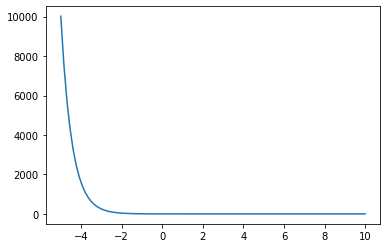

In [39]:
plt.plot(dGr, K)
plt.show()

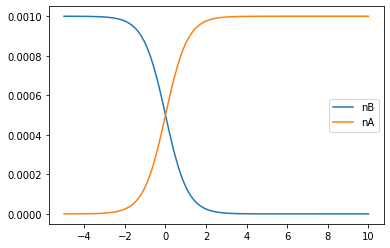

In [41]:
xB = K/(1+K)
n0 = 1e-3
plt.plot(dGr, xB * n0, label='nB')
plt.plot(dGr, (1-xB) * n0, label='nA')
plt.legend()
plt.show()